In [92]:
%matplotlib inline
import torchio as tio
import torch
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

def compute_diff(volume, order_of_derivation=1):
    """Compute the continuity of a volume.

    Args:
        volume (np.array): 4D volume (batch, height, width, channels)
        order_of_derivation (int, optional): Order of derivation. Defaults to 1.

    Returns:
        np.array: Continuity of the volume in specified order of derivation ranging in [0, 1]
    """
    diff = volume.astype(np.int16)
    diff = diff[:, :, :, order_of_derivation:] - diff[:, :, :, :-order_of_derivation]
    diff = np.abs(diff)
    _diff = diff.sum(axis=(0, 1, 2)) / (diff.shape[0] * diff.shape[1] * diff.shape[2])
    return diff.mean(), _diff.std()

def morph_open(volume, structuring_element, iterations=1):
    for _ in range(iterations):
        volume = binary_erosion(volume, structuring_element)
        volume = binary_dilation(volume, structuring_element)
    return volume

def morph_close(volume, structuring_element, iterations=1):
    for _ in range(iterations):
        volume = binary_dilation(volume, structuring_element)
        volume = binary_erosion(volume, structuring_element)
    return volume

def create_spherical_structure(radius):
    # Create a grid of the appropriate size
    L = np.arange(-radius, radius+1)
    X, Y, Z = np.meshgrid(L, L, L)
    
    # Calculate the distance from the center
    distance = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create the spherical structuring element
    structure = distance <= radius
    return structure

def create_elipsoidal_structure(radius_x, radius_y, radius_z):
    # Create a grid of the appropriate size
    r_max = max(radius_x, radius_y, radius_z)
    L = np.arange(-r_max, r_max+1)
    X, Y, Z = np.meshgrid(L, L, L)
    
    # Calculate the distance from the center
    distance = (X/radius_x)**2 + (Y/radius_y)**2 + (Z/radius_z)**2
    
    # Create the spherical structuring element
    structure = distance <= 1
    return structure

def compute_dice(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum())

In [104]:
validataion_volume_paths

[PosixPath('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/704-003.nii.gz'),
 PosixPath('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/101-019.nii.gz'),
 PosixPath('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_1/validation/106-002.nii.gz'),
 PosixPath('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_1/validation/101-044.nii.gz'),
 PosixPath('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_2/validation/401-004.nii.gz'),
 PosixPath('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_2/validation/701-013.nii.gz')]

In [139]:
fold_0_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation')
fold_1_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_1/validation')
fold_2_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_2/validation')
fold_dirs = [fold_0_dir, fold_1_dir, fold_2_dir]

label_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/labelsTr')
validataion_volume_paths = []
validataion_label_paths = []
for fold_dir in fold_dirs:
    for nifty in fold_dir.glob('*.nii.gz'):
        validataion_volume_paths.append(nifty)
        assert (label_dir / nifty.name).exists(), "Label not found, please check the label directory."
        validataion_label_paths.append(label_dir / nifty.name)

fold_0_3d_32x160x128 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x160x128_b10/fold_0_pretrained_LaW/validation')
fold_1_3d_32x160x128 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x160x128_b10/fold_1_pretrained_LaW/validation')
fold_2_3d_32x160x128 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x160x128_b10/fold_2_pretrained_LaW/validation')

d3_volume_paths = []
d3_label_paths = []
for fold_dir in [fold_0_3d_32x160x128, fold_1_3d_32x160x128, fold_2_3d_32x160x128]:
    for nifty in fold_dir.glob('*.nii.gz'):
        d3_volume_paths.append(nifty)
        assert (label_dir / nifty.name).exists(), "Label not found, please check the label directory."
        d3_label_paths.append(label_dir / nifty.name)

fold_0_3d_32x512x512 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_0_pretrained_LaW/validation')
fold_1_3d_32x512x512 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_1_pretrained_LaW/validation')
fold_2_3d_32x512x512 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_2_pretrained_LaW/validation')

d3_512_volume_paths = []
d3_512_label_paths = []
for fold_dir in [fold_0_3d_32x512x512, fold_1_3d_32x512x512, fold_2_3d_32x512x512]:
    for nifty in fold_dir.glob('*.nii.gz'):
        d3_512_volume_paths.append(nifty)
        assert (label_dir / nifty.name).exists(), "Label not found, please check the label directory."
        d3_512_label_paths.append(label_dir / nifty.name)

In [94]:
def evaluate_a_post_process_function(volumn_path, label_path, post_process_function):
    volume = tio.ScalarImage(volumn_path).data.numpy()
    label = tio.LabelMap(label_path).data.numpy()
    post_procesed_volumn = post_process_function(volume[0])[np.newaxis, ...]
    dice = compute_dice(post_procesed_volumn, label)
    derivative = compute_diff(post_procesed_volumn)
    derivative_2 = compute_diff(post_procesed_volumn, 2)
    derivative_3 = compute_diff(post_procesed_volumn, 3)
    return {
        'dice': dice,
        'derivative': [derivative, derivative_2, derivative_3]
    }

def create_post_process_function(structure):
    def post_process_function(volume):

        assert volume.min() == 0 and volume.max() == 1, "Volume must be binary, 0 or 1 but got {} and {}".format(volume.min(), volume.max())
        assert np.unique(structure).size == 2, "Structure must be binary."

        volume = volume == 1
        volume = morph_open(volume, structure, iterations=1)
        volume = morph_close(volume, structure, iterations=1)
        return volume
    return post_process_function

def get_post_process_functions():
    sphere_r1 = create_spherical_structure(1)
    sphere_r2 = create_spherical_structure(2)
    sphere_r3 = create_spherical_structure(3)

    ellipse_r1x1x2 = create_elipsoidal_structure(1, 1, 2)
    ellipse_r1x1x3 = create_elipsoidal_structure(1, 1, 3)

    ellipse_r2x2x3 = create_elipsoidal_structure(2, 2, 3)
    ellipse_r2x2x4 = create_elipsoidal_structure(2, 2, 3)

    operations = [
        ('sphere_r1', create_post_process_function(sphere_r1)),
        ('sphere_r2', create_post_process_function(sphere_r2)),
        ('sphere_r3', create_post_process_function(sphere_r3)),
        ('ellipse_r1x1x2', create_post_process_function(ellipse_r1x1x2)),
        ('ellipse_r1x1x3', create_post_process_function(ellipse_r1x1x3)),
        ('ellipse_r2x2x3', create_post_process_function(ellipse_r2x2x3)),
        ('ellipse_r2x2x4', create_post_process_function(ellipse_r2x2x4))
    ]
    return operations

In [95]:
dices = defaultdict(list)
derivative_1s = defaultdict(list)
derivative_2s = defaultdict(list)
derivative_3s = defaultdict(list)

post_process_functions = get_post_process_functions()
for validation_volume_path, validation_label_path in zip(validataion_volume_paths, validataion_label_paths):

    for name, func in post_process_functions:
        result = evaluate_a_post_process_function(validation_volume_path, validation_label_path, func)
        dice = result['dice']
        derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

        dices[name].append(dice)
        derivative_1s[name].append(derivative_1_mean_and_std)
        derivative_2s[name].append(derivative_2_mean_and_std)
        derivative_3s[name].append(derivative_3_mean_and_std)

In [140]:
import copy

dices_with_3d = copy.deepcopy(dices)
derivative_1s_with_3d = copy.deepcopy(derivative_1s)
derivative_2s_with_3d = copy.deepcopy(derivative_2s)
derivative_3s_with_3d = copy.deepcopy(derivative_3s)

noop = lambda x: x
name = '2d_original'
for validation_volume_path, validation_label_path in zip(validataion_volume_paths, validataion_label_paths):
    result = evaluate_a_post_process_function(validation_volume_path, validation_label_path, noop)
    dice = result['dice']
    derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

    dices_with_3d[name].append(dice)
    derivative_1s_with_3d[name].append(derivative_1_mean_and_std)
    derivative_2s_with_3d[name].append(derivative_2_mean_and_std)
    derivative_3s_with_3d[name].append(derivative_3_mean_and_std)

name = '3d_32x160x128'
for volume_path, label_path in zip(d3_volume_paths, d3_label_paths):
    result = evaluate_a_post_process_function(volume_path, label_path, noop)
    dice = result['dice']
    derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

    dices_with_3d[name].append(dice)
    derivative_1s_with_3d[name].append(derivative_1_mean_and_std)
    derivative_2s_with_3d[name].append(derivative_2_mean_and_std)
    derivative_3s_with_3d[name].append(derivative_3_mean_and_std)

name = '3d_32x512x512'
for volume_path, label_path in zip(d3_512_volume_paths, d3_512_label_paths):
    result = evaluate_a_post_process_function(volume_path, label_path, noop)
    dice = result['dice']
    derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

    dices_with_3d[name].append(dice)
    derivative_1s_with_3d[name].append(derivative_1_mean_and_std)
    derivative_2s_with_3d[name].append(derivative_2_mean_and_std)
    derivative_3s_with_3d[name].append(derivative_3_mean_and_std)


In [142]:
dices_with_3d

defaultdict(list,
            {'sphere_r1': [0.8000042167142444,
              0.7170348415666035,
              0.7934350233377114,
              0.7224139459823724,
              0.7744650420047502,
              0.6449905909589787],
             'sphere_r2': [0.7928771259924663,
              0.6988642235184496,
              0.7947434033335596,
              0.7122780753938033,
              0.7575128917394134,
              0.6130254381439414],
             'sphere_r3': [0.7846391451784864,
              0.672674747362147,
              0.7901921167247735,
              0.7010907542452703,
              0.7343316506172316,
              0.5760213943939814],
             'ellipse_r1x1x2': [0.7911959113298973,
              0.6976172220673599,
              0.7949298063242931,
              0.7125050581822279,
              0.7551470841113554,
              0.6119810837809395],
             'ellipse_r1x1x3': [0.7777786171752737,
              0.6652159821795435,
              0.7888

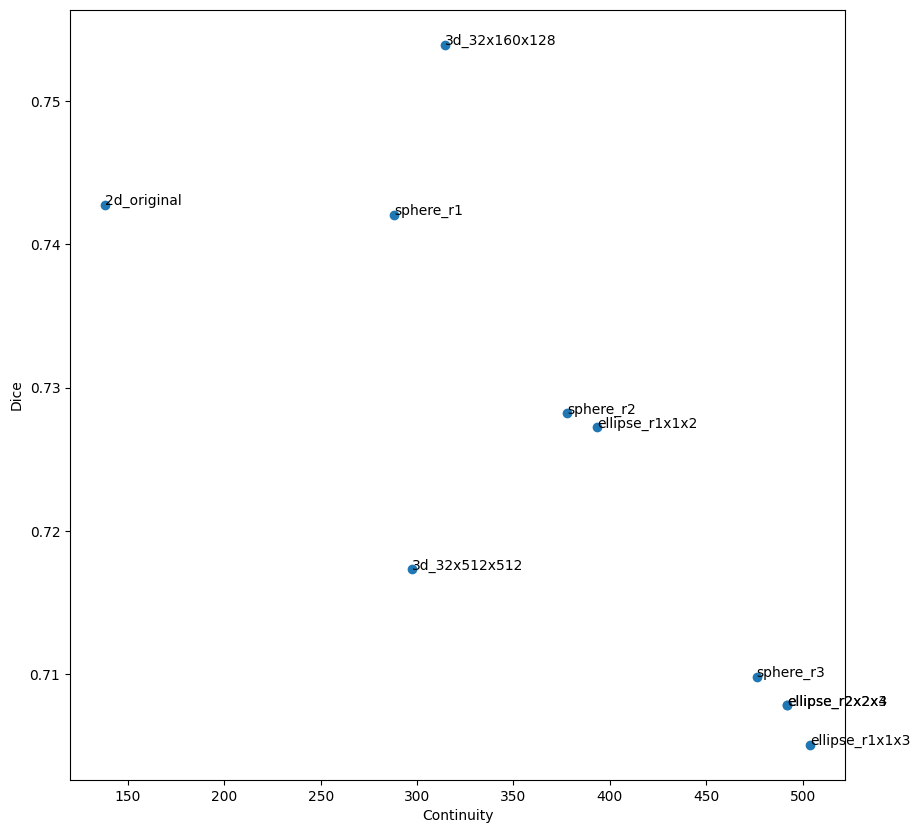

In [141]:
def average_std_of_same_sample_size(stds):
    return np.sqrt(np.sum(stds ** 2) / len(stds))

def extract_mean_and_std(derivative):
    means = []
    stds = []
    for mean, std in derivative:
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)
    
# x = [avg_continuity_3d_32x512x512, avg_continuity_3d_32x160x128, avg_continuity_2d_original, avg_continuity_2d_sphere_r1, avg_continuity_2d_sphere_r2, avg_continuity_2d_ellipse_r1x1x3]
operation_names = list(dices_with_3d.keys())
avg_dice = [np.mean(dices_with_3d[name]) for name in operation_names]


avg_continuity_1st = np.array([np.mean( extract_mean_and_std(derivative_1s_with_3d[name])[0] ) for name in operation_names])
avg_continuity_1st = 1 / avg_continuity_1st

avg_std_continuity_1st = np.array([average_std_of_same_sample_size( extract_mean_and_std(derivative_1s_with_3d[name])[1] ) for name in operation_names])

# avg_continuity_2nd = np.array([np.mean(derivative_2s[name]) for name in operation_names])
# avg_continuity_2nd = 1 / avg_continuity_2nd

# avg_continuity_3rd = np.array([np.mean(derivative_3s[name]) for name in operation_names])
# avg_continuity_3rd = 1 / avg_continuity_3rd

x = avg_continuity_1st
y = avg_dice


plt.figure(figsize=(10, 10))
plt.scatter(x, y)
plt.xlabel('Continuity')
plt.ylabel('Dice')
for i, txt in enumerate(operation_names):
    plt.annotate(txt, (x[i], y[i])) # put the label on the point

plt.show()

In [ ]:
continuity_gt = []
continuity_3d_32x512x512 = []
continuity_3d_32x160x128 = []
continuity_2d_original = []
continuity_2d_sphere_r1 = []
continuity_2d_sphere_r2 = []
continuity_2d_ellipse_r1x1x3 = []

continuity_gt_2nd = []
continuity_3d_32x512x512_2nd = []
continuity_3d_32x160x128_2nd = []
continuity_2d_original_2nd = []
continuity_2d_sphere_r1_2nd = []
continuity_2d_sphere_r2_2nd = []
continuity_2d_ellipse_r1x1x3_2nd = []

dice_gt = []
dice_3d_32x512x512 = []
dice_3d_32x160x128 = []
dice_2d_original = []
dice_2d_sphere_r1 = []
dice_2d_sphere_r2 = []
dice_2d_ellipse_r1x1x3 = []

for test_set in ['101-045', '706-005']:
    subject = tio.Subject(
        image = tio.ScalarImage(f'/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/imagesTs/{test_set}_0000.nii.gz'),
        ground_truth = tio.ScalarImage(f'/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/labelsTs/{test_set}.nii.gz'),
        pred_3d_32x512x512=tio.ScalarImage(f'/home/naravich/projects/ModelsGenesis/notebooks/predictions/3d_32x512x512_b2/fold_0/{test_set}.nii.gz'),
        pred_3d_32x160x128=tio.ScalarImage(f'/home/naravich/projects/ModelsGenesis/notebooks/predictions/3d_32x160x128_b10/fold_0/{test_set}.nii.gz'),
        pred_2d_512x512=tio.ScalarImage(f'/home/naravich/projects/ModelsGenesis/notebooks/predictions/2d/fold_0/{test_set}.nii.gz')
    )

    sphere = create_spherical_structure(1)
    sphere2 = create_spherical_structure(2)
    elipse = create_elipsoidal_structure(1, 1, 2)

    closed = morph_open(subject.pred_2d_512x512.numpy()[0] > 0.5, sphere, 1)
    closed = morph_close(closed > 0.5, sphere, 1)
    closed = closed.astype(np.uint8)
    closed = np.expand_dims(closed, axis=0)

    closed_2 = morph_open(subject.pred_2d_512x512.numpy()[0] > 0.5, sphere2, 1)
    closed_2 = morph_close(closed_2, sphere2, 1)
    closed_2 = closed_2.astype(np.uint8)
    closed_2 = np.expand_dims(closed_2, axis=0)

    close_elipse = morph_open(subject.pred_2d_512x512.numpy()[0] > 0.5, elipse, 1)
    close_elipse = morph_close(close_elipse, elipse, 1)
    close_elipse = close_elipse.astype(np.uint8)
    close_elipse = np.expand_dims(close_elipse, axis=0)

    _continuity_gt = compute_diff(subject.ground_truth.numpy().astype(np.int16))
    _continuity_3d_32x512x512 = compute_diff(subject.pred_3d_32x512x512.numpy().astype(np.int16))
    _continuity_3d_32x160x128 = compute_diff(subject.pred_3d_32x160x128.numpy().astype(np.int16))
    _continuity_2d_original = compute_diff(subject.pred_2d_512x512.numpy().astype(np.int16))
    _continuity_2d_sphere_r1 = compute_diff(closed.astype(np.int16))
    _continuity_2d_sphere_r2 = compute_diff(closed_2.astype(np.int16))
    _continuity_2d_ellipse_r1x1x3 = compute_diff(close_elipse.astype(np.int16))

    continuity_gt.append(_continuity_gt)
    continuity_3d_32x512x512.append(_continuity_3d_32x512x512)
    continuity_3d_32x160x128.append(_continuity_3d_32x160x128)
    continuity_2d_original.append(_continuity_2d_original)
    continuity_2d_sphere_r1.append(_continuity_2d_sphere_r1)
    continuity_2d_sphere_r2.append(_continuity_2d_sphere_r2)
    continuity_2d_ellipse_r1x1x3.append(_continuity_2d_ellipse_r1x1x3)

    _continuity_gt_2nd = compute_diff(subject.ground_truth.numpy().astype(np.int16), 2)
    _continuity_3d_32x512x512_2nd = compute_diff(subject.pred_3d_32x512x512.numpy().astype(np.int16), 2)
    _continuity_3d_32x160x128_2nd = compute_diff(subject.pred_3d_32x160x128.numpy().astype(np.int16), 2)
    _continuity_2d_original_2nd = compute_diff(subject.pred_2d_512x512.numpy().astype(np.int16), 2)
    _continuity_2d_sphere_r1_2nd = compute_diff(closed.astype(np.int16), 2)
    _continuity_2d_sphere_r2_2nd = compute_diff(closed_2.astype(np.int16), 2)
    _continuity_2d_ellipse_r1x1x3_2nd = compute_diff(close_elipse.astype(np.int16), 2)

    continuity_gt_2nd.append(_continuity_gt_2nd)
    continuity_3d_32x512x512_2nd.append(_continuity_3d_32x512x512_2nd)
    continuity_3d_32x160x128_2nd.append(_continuity_3d_32x160x128_2nd)
    continuity_2d_original_2nd.append(_continuity_2d_original_2nd)
    continuity_2d_sphere_r1_2nd.append(_continuity_2d_sphere_r1_2nd)
    continuity_2d_sphere_r2_2nd.append(_continuity_2d_sphere_r2_2nd)
    continuity_2d_ellipse_r1x1x3_2nd.append(_continuity_2d_ellipse_r1x1x3_2nd)

    _dice_gt = compute_dice(subject.ground_truth.numpy()[0], subject.ground_truth.numpy()[0])
    _dice_3d_32x512x512 = compute_dice(subject.pred_3d_32x512x512.numpy()[0] > 0.5, subject.ground_truth.numpy()[0])
    _dice_3d_32x160x128 = compute_dice(subject.pred_3d_32x160x128.numpy()[0] > 0.5, subject.ground_truth.numpy()[0])
    _dice_2d_original = compute_dice(subject.pred_2d_512x512.numpy()[0] > 0.5, subject.ground_truth.numpy()[0])
    _dice_2d_sphere_r1 = compute_dice(closed, subject.ground_truth.numpy()[0])
    _dice_2d_sphere_r2 = compute_dice(closed_2, subject.ground_truth.numpy()[0])
    _dice_2d_ellipse_r1x1x3 = compute_dice(close_elipse, subject.ground_truth.numpy()[0])

    dice_gt.append(_dice_gt)
    dice_3d_32x512x512.append(_dice_3d_32x512x512)
    dice_3d_32x160x128.append(_dice_3d_32x160x128)
    dice_2d_original.append(_dice_2d_original)
    dice_2d_sphere_r1.append(_dice_2d_sphere_r1)
    dice_2d_sphere_r2.append(_dice_2d_sphere_r2)
    dice_2d_ellipse_r1x1x3.append(_dice_2d_ellipse_r1x1x3)


    gt_diff = subject.ground_truth.numpy().astype(np.int16)
    gt_diff = gt_diff[:, :, :, 1:] - gt_diff[:, :, :, :-1]
    gt_diff = np.abs(gt_diff)

    pred_3d_32x512x512_diff = subject.pred_3d_32x512x512.numpy().astype(np.int16)
    pred_3d_32x512x512_diff = pred_3d_32x512x512_diff[:, :, :, 1:] - pred_3d_32x512x512_diff[:, :, :, :-1]
    pred_3d_32x512x512_diff = np.abs(pred_3d_32x512x512_diff)

    pred_3d_32x160x128_diff = subject.pred_3d_32x160x128.numpy().astype(np.int16)
    pred_3d_32x160x128_diff = pred_3d_32x160x128_diff[:, :, :, 1:] - pred_3d_32x160x128_diff[:, :, :, :-1]
    pred_3d_32x160x128_diff = np.abs(pred_3d_32x160x128_diff)

    pred_2d_512x512_diff = subject.pred_2d_512x512.numpy().astype(np.int16)
    pred_2d_512x512_diff = pred_2d_512x512_diff[:, :, :, 1:] - pred_2d_512x512_diff[:, :, :, :-1]
    pred_2d_512x512_diff = np.abs(pred_2d_512x512_diff)


In [26]:
avg_continuity_gt = np.array(continuity_gt).mean()
avg_continuity_3d_32x512x512 = np.array(continuity_3d_32x512x512).mean()
avg_continuity_3d_32x160x128 = np.array(continuity_3d_32x160x128).mean()
avg_continuity_2d_original = np.array(continuity_2d_original).mean()
avg_continuity_2d_sphere_r1 = np.array(continuity_2d_sphere_r1).mean()
avg_continuity_2d_sphere_r2 = np.array(continuity_2d_sphere_r2).mean()
avg_continuity_2d_ellipse_r1x1x3 = np.array(continuity_2d_ellipse_r1x1x3).mean()

avg_continuity_gt_2nd = np.array(continuity_gt_2nd).mean()
avg_continuity_3d_32x512x512_2nd = np.array(continuity_3d_32x512x512_2nd).mean()
avg_continuity_3d_32x160x128_2nd = np.array(continuity_3d_32x160x128_2nd).mean()
avg_continuity_2d_original_2nd = np.array(continuity_2d_original_2nd).mean()
avg_continuity_2d_sphere_r1_2nd = np.array(continuity_2d_sphere_r1_2nd).mean()
avg_continuity_2d_sphere_r2_2nd = np.array(continuity_2d_sphere_r2_2nd).mean()
avg_continuity_2d_ellipse_r1x1x3_2nd = np.array(continuity_2d_ellipse_r1x1x3_2nd).mean()


avg_dice_gt = np.array(dice_gt).mean()
avg_dice_3d_32x512x512 = np.array(dice_3d_32x512x512).mean()
avg_dice_3d_32x160x128 = np.array(dice_3d_32x160x128).mean()
avg_dice_2d_original = np.array(dice_2d_original).mean()
avg_dice_2d_sphere_r1 = np.array(dice_2d_sphere_r1).mean()
avg_dice_2d_sphere_r2 = np.array(dice_2d_sphere_r2).mean()
avg_dice_2d_ellipse_r1x1x3 = np.array(dice_2d_ellipse_r1x1x3).mean()

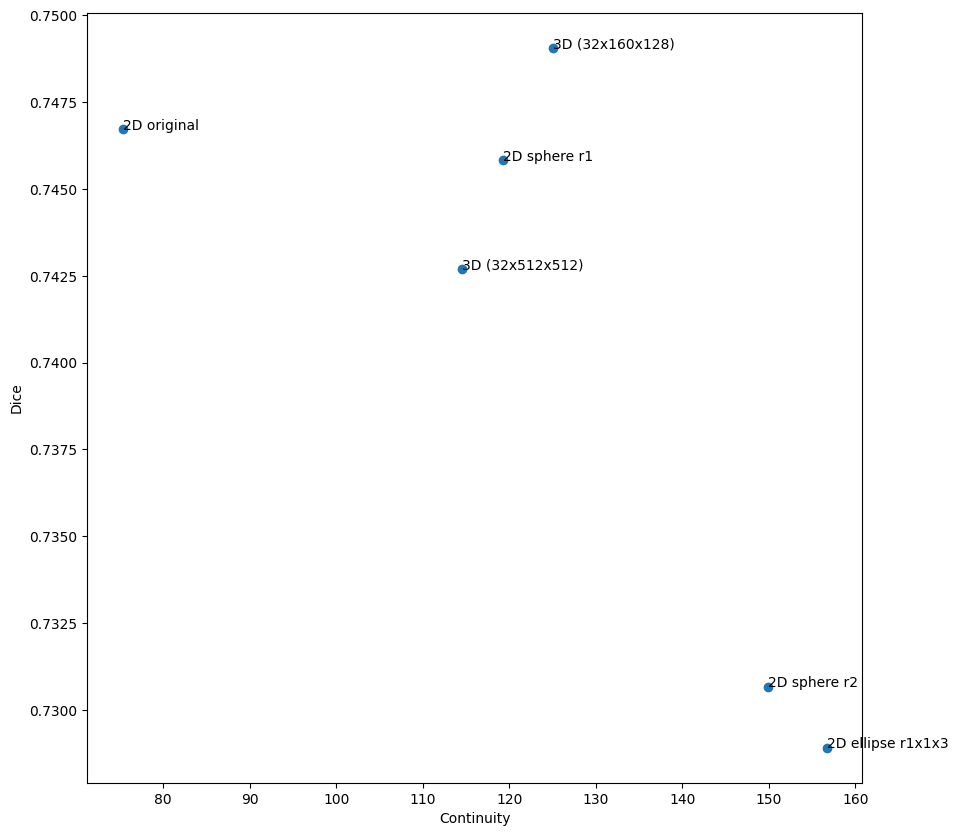

In [27]:
# x = [avg_continuity_3d_32x512x512, avg_continuity_3d_32x160x128, avg_continuity_2d_original, avg_continuity_2d_sphere_r1, avg_continuity_2d_sphere_r2, avg_continuity_2d_ellipse_r1x1x3]

x = [avg_continuity_3d_32x512x512_2nd, avg_continuity_3d_32x160x128_2nd, avg_continuity_2d_original_2nd, avg_continuity_2d_sphere_r1_2nd, avg_continuity_2d_sphere_r2_2nd, avg_continuity_2d_ellipse_r1x1x3_2nd]
x = np.array(x)
x = 1/x
y = [avg_dice_3d_32x512x512, avg_dice_3d_32x160x128, avg_dice_2d_original, avg_dice_2d_sphere_r1, avg_dice_2d_sphere_r2, avg_dice_2d_ellipse_r1x1x3]
y = np.array(y)
# y = np.log(y)

labels = ['3D (32x512x512)', '3D (32x160x128)', '2D original', '2D sphere r1', '2D sphere r2', '2D ellipse r1x1x3']

plt.figure(figsize=(10, 10))
plt.scatter(x, y)
plt.xlabel('Continuity')
plt.ylabel('Dice')
for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i])) # put the label on the point

plt.show()

In [ ]:

print(f'Continuity GT: {continuity_gt:.3f}e-2 (Dice {dice_gt:.3f})')
print(f'Continuity 3D (32x512x512): {continuity_3d_32x512x512:.3f}e-2 (Dice {dice_3d_32x512x512:.3f})')
print(f'Continuity 3D (32x160x128): {continuity_3d_32x160x128:.3f}e-2 (Dice {dice_3d_32x160x128:.3f})')
print(f'Continuity 2D original: {continuity_2d_original:.3f}e-2 (Dice {dice_2d_original:.3f})')
print(f'Continuity 2D post-processed (sphere r1): {continuity_2d_sphere_r1:.3f}e-2 (Dice {dice_2d_sphere_r1:.3f})')
print(f'Continuity 2D post-processed (sphere r2): {continuity_2d_sphere_r2:.3f}e-2 (Dice {dice_2d_sphere_r2:.3f})')
print(f'Continuity 2D post-processed (ellipse r1x1x3): {continuity_2d_ellipse_r1x1x3:.3f}e-2 (Dice {dice_2d_ellipse_r1x1x3:.3f})')